### LSTM for Multivariate Time Series Forecasting

In [7]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('capacity-prediction.csv', header=0, index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2019-11-12 12:49:54 to 2020-11-11 17:59:23
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   charge-discharge magnitude  1000 non-null   int64
 1   capacity                    1000 non-null   int64
dtypes: int64(2)
memory usage: 23.4+ KB


### Multivariate LSTM Forecast Model

#### LSTM Data Preparation

In [6]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[3], axis = 1, inplace = True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var1(t)
1      0.250   0.250000    0.625
2      0.625   0.055556    0.125
3      0.125   0.361111    0.875
4      0.875   0.777778    0.375
5      0.375   0.638889    0.625


### Define and Fit Model

In [14]:
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
n_train = 200
train = values[n_train:, :]
test = values[:n_train, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
X_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(X_train.shape, train_y.shape, X_test.shape, test_y.shape)
print(X_train)

(799, 1, 2) (799,) (200, 1, 2) (200,)
[[[0.75       0.22222222]]

 [[0.5        0.05555556]]

 [[0.625      0.05555556]]

 ...

 [[0.125      0.7777778 ]]

 [[0.         0.7222222 ]]

 [[0.25       0.9166667 ]]]


In [12]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import RepeatVector
from keras.layers import Flatten

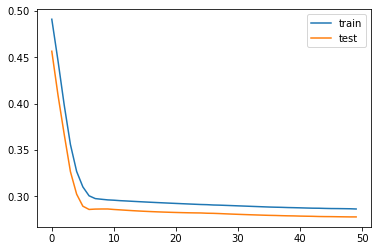

In [8]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate Model

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
model = Sequential()
model.add(keras.layers.LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.summary
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# fit network
history = model.fit(X_train,train_y, epochs = 10, batch_size = 10,
                   validation_data = (X_test, test_y), verbose = 1,
                   shuffle = False)



# make prediction
y_hat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0],2))
# invert scaling for forecast
inv_y_hat = np.concatenate((y_hat, X_test[:, -1:]), axis = 1)
inv_y_hat = scaler.inverse_transform(inv_y_hat)
inv_y_hat = inv_y_hat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y),1))
invers_y = np.concatenate((test_y, X_test[:,-1:]), axis = 1)
invers_y = scaler.inverse_transform(invers_y)
invers_y = invers_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(invers_y, inv_y_hat))
print('Test RMSE:  %.3f' % rmse)

Train on 200 samples, validate on 799 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3277 - val_loss: 0.2384
Epoch 2/10
200/200 [==============================] - 0s 610us/step - loss: 0.2038 - val_loss: 0.1498
Epoch 3/10
200/200 [==============================] - 0s 617us/step - loss: 0.1405 - val_loss: 0.1183
Epoch 4/10
200/200 [==============================] - 0s 691us/step - loss: 0.1257 - val_loss: 0.1160
Epoch 5/10
200/200 [==============================] - 0s 583us/step - loss: 0.1213 - val_loss: 0.1146
Epoch 6/10
200/200 [==============================] - 0s 643us/step - loss: 0.1229 - val_loss: 0.1132
Epoch 7/10
200/200 [==============================] - 0s 658us/step - loss: 0.1169 - val_loss: 0.1121
Epoch 8/10
200/200 [==============================] - 0s 594us/step - loss: 0.1168 - val_loss: 0.1112
Epoch 9/10
200/200 [==============================] - 0s 650us/step - loss: 0.1160 - val_loss: 0.1103
Epoch 10/10
200/200 [=================

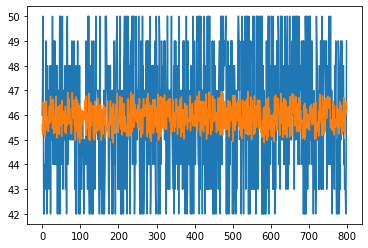

In [10]:
# line plot of observed vs predicted
pyplot.plot(invers_y)
pyplot.plot(inv_y_hat)
pyplot.show()